In [1]:
import sys
import os
import pickle
import keras
import datetime
import matplotlib
import copy

import numpy as np
import tensorflow as tf
from keras import backend as K
from tqdm import tqdm
from matplotlib import pyplot as plt

sys.path.append(os.path.abspath('../'))
import helpers
from helpers.data_generator import process_data, DataGenerator
from helpers.normalization import normalize, denormalize, renormalize
from helpers.custom_losses import denorm_loss, hinge_mse_loss, percent_baseline_error, baseline_MAE
from helpers.custom_losses import percent_correct_sign, baseline_MAE, normed_mse, mean_diff_sum_2, max_diff_sum_2, mean_diff2_sum2, max_diff2_sum2

Using TensorFlow backend.
/home/wconlin/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/wconlin/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/wconlin/.conda/envs/tfgpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/wconlin/.conda/envs/tfg

In [2]:
config = tf.ConfigProto(intra_op_parallelism_threads=16,
                            inter_op_parallelism_threads=16,
                            allow_soft_placement=True,
                            device_count={'CPU': 8,
                                          'GPU': 0})
session = tf.Session(config=config)
K.set_session(session)

In [3]:
matplotlib_colors = [(0.1215, 0.4667, 0.7058), # blue
                     (1.0000, 0.4980, 0.0549), # orange
                     (0.1725, 0.6275, 0.1725), # green
                     (0.8392, 0.1529, 0.1568), # red
                     (0.5804, 0.4039, 0.7412), # violet
                     (0.4980, 0.4980, 0.4980), # grey
                     (0.0902, 0.7450, 0.8117)] # cyan

matlab_colors=[(0.0000, 0.4470, 0.7410), # blue
               (0.8500, 0.3250, 0.0980), # reddish orange
               (0.9290, 0.6940, 0.1250), # yellow
               (0.4940, 0.1840, 0.5560), # purple
               (0.4660, 0.6740, 0.1880), # light green
               (0.3010, 0.7450, 0.9330), # cyan
               (0.6350, 0.0780, 0.1840)] # dark red

colorblind_colors = [(0.0000, 0.4500, 0.7000), # blue
                     (0.8359, 0.3682, 0.0000), # vermillion
                     (0.0000, 0.6000, 0.5000), # bluish green
                     (0.9500, 0.9000, 0.2500), # yellow
                     (0.3500, 0.7000, 0.9000), # sky blue
                     (0.8000, 0.6000, 0.7000), # reddish purple
                     (0.9000, 0.6000, 0.0000)] # orange

dashes = [(1.0, 0.0, 0.0, 0.0, 0.0, 0.0), # solid
          (3.7, 1.6, 0.0, 0.0, 0.0, 0.0), # dashed
          (1.0, 1.6, 0.0, 0.0, 0.0, 0.0), # dotted
          (6.4, 1.6, 1.0, 1.6, 0.0, 0.0), # dot dash
          (3.0, 1.6, 1.0, 1.6, 1.0, 1.6), # dot dot dash
          (6.0, 4.0, 0.0, 0.0, 0.0, 0.0), # long dash
          (1.0, 1.6, 3.0, 1.6, 3.0, 1.6)] # dash dash dot

from matplotlib import rcParams, cycler
matplotlib.rcdefaults()
rcParams['font.family'] = 'DejaVu Serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['font.size'] = 12
rcParams['figure.facecolor'] = (1,1,1,1)
rcParams['figure.figsize'] = (16,8)
rcParams['figure.dpi'] = 96
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.labelsize'] =  'large'
rcParams['axes.titlesize'] = 'x-large'
rcParams['lines.linewidth'] = 2.5
rcParams['lines.solid_capstyle'] = 'round'
rcParams['lines.dash_capstyle'] = 'round'
rcParams['lines.dash_joinstyle'] = 'round'
rcParams['xtick.labelsize'] = 'large'
rcParams['ytick.labelsize'] = 'large'

color_cycle = cycler(color=colorblind_colors)
dash_cycle = cycler(dashes=dashes)
rcParams['axes.prop_cycle'] =  color_cycle

In [4]:
file_path = '/home/jabbate/run_results_12_11/model-conv2d_profiles-dens-temp-q_EFIT01-rotation-press_EFIT01_act-curr_target-pinj-tinj-target_density-bt_targ-dens-temp-q_EFIT01-rotation-press_EFIT01_profLB-0_actLB-6_ftop-True_11Dec19-18-30_Scenario-12.h5'
file_path = '/home/jabbate/run_results_1_24/profiles-temp-dens-rotation-itemp-idens_act-target_density-curr_target-pinj-tinj_size_32_25Jan20-16-34_Scenario-1.h5'
base_path = os.path.expanduser('~/run_results_01_28')
files = [foo for foo in os.listdir(base_path) if foo.endswith('.h5')]

model = keras.models.load_model(file_path, compile=False)
print('loaded model: ' + file_path.split('/')[-1])
file_path = file_path[:-3] + '_params.pkl'
with open(file_path, 'rb') as f:
    scenario = pickle.load(f, encoding='latin1')
print('loaded dict: ' + file_path.split('/')[-1])
print('with parameters: ' + str(scenario.keys()))

loaded model: profiles-temp-dens-rotation-itemp-idens_act-target_density-curr_target-pinj-tinj_size_32_25Jan20-16-34_Scenario-1.h5
loaded dict: profiles-temp-dens-rotation-itemp-idens_act-target_density-curr_target-pinj-tinj_size_32_25Jan20-16-34_Scenario-1_params.pkl
with parameters: dict_keys(['model_kwargs', 'actuator_names', 'input_profile_names', 'target_profile_names', 'scalar_input_names', 'profile_downsample', 'model_type', 'std_activation', 'sample_weighting', 'hinge_weight', 'mse_weight_power', 'mse_weight_edge', 'mse_power', 'batch_size', 'epochs', 'flattop_only', 'predict_deltas', 'raw_data_path', 'process_data', 'processed_filename_base', 'optimizer', 'optimizer_kwargs', 'shuffle_generators', 'pruning_functions', 'normalization_method', 'window_length', 'window_overlap', 'profile_lookback', 'actuator_lookback', 'lookahead', 'sample_step', 'uniform_normalization', 'train_frac', 'val_frac', 'nshots', 'excluded_shots', 'lookbacks', 'sig_names', 'dt', 'normalization_dict', 'pr

In [5]:
full_data_oath = '/scratch/gpfs/jabbate/full_data/train_data_full.pkl'
test_data_path = '/scratch/gpfs/jabbate/full_data/test_data.pkl' 
traindata, valdata, normalization_dict = helpers.data_generator.process_data(test_data_path,
                                                      scenario['sig_names'],
                                                      scenario['normalization_method'],
                                                      scenario['window_length'],
                                                      scenario['window_overlap'],
                                                      scenario['lookbacks'],
                                                      scenario['lookahead'],
                                                      scenario['sample_step'],
                                                      scenario['uniform_normalization'],
                                                      1, #scenario['train_frac'],
                                                      0, #scenario['val_frac'],
                                                      scenario['nshots'],
                                                      2, #scenario['verbose']
                                                      scenario['flattop_only'],
                                                      randomize=False,
                                                      pruning_functions=scenario['pruning_functions'],
                                                      excluded_shots = scenario['excluded_shots'],
                                                      delta_sigs = [])
traindata = helpers.normalization.renormalize(helpers.normalization.denormalize(traindata.copy(),normalization_dict),scenario['normalization_dict'])
train_generator = DataGenerator(traindata,
                                scenario['batch_size'],
                                scenario['input_profile_names'],
                                scenario['actuator_names'],
                                scenario['target_profile_names'],
                                scenario['scalar_input_names'],
                                scenario['lookbacks'],
                                scenario['lookahead'],
                                scenario['predict_deltas'],
                                scenario['profile_downsample'],
                                False,
                                sample_weights = None) #scenario['shuffle_generators'])

Loading
Signals: curr_target, dens, density_estimate, drsep_EFIT01, idens, itemp, kappa_EFIT01, li_EFIT01, pinj, q95_EFIT01, rotation, target_density, temp, tinj, triangularity_bot_EFIT01, triangularity_top_EFIT01
Number of useable shots:  1098
Number of shots used:  1098
Total number of timesteps:  122217
Shots with Complete NaN: 
84304 samples total
Removing ECH
Removed 45638 samples
38666 samples remaining
Removing timesteps WITHOUT gas feedback
Removed 5149 samples
33517 samples remaining
Removing weird I-coils
Removed 7301 samples
26216 samples remaining
Removing NaN
Removed 0 samples
26216 samples remaining
Removing dudtrip
Removed 620 samples
25596 samples remaining
25596 samples remaining after pruning


Normalizing:  24%|##4       | 6/25 [00:00<00:00, 56.79it/s]

Total number of samples:  25596
Number of training samples:  25596
Number of validation samples:  0


Normalizing: 100%|##########| 25/25 [00:00<00:00, 48.53it/s]


In [6]:
optimizer = keras.optimizers.Adam()
loss = keras.metrics.mean_squared_error
metrics = [keras.metrics.mean_squared_error, normed_mse, mean_diff_sum_2, max_diff_sum_2, mean_diff2_sum2, max_diff2_sum2]

In [7]:
model.compile(optimizer, loss, metrics)

outs = model.evaluate_generator(train_generator, verbose=1, workers=8, use_multiprocessing=True)

200/200 [==============================] - 15s 74ms/step


In [8]:
evaluation_metrics = {name: val for name,val in zip(model.metrics_names,outs)}
for metric in metrics:
    name = metric if isinstance(metric,str) else str(metric.__name__)
    print(name)
    s = 0
    for key,val in evaluation_metrics.items():
        if name in key:
            s += val/len(model.outputs)
    print(s)
    evaluation_metrics[name] = s
    
    
scenario['evaluation_metrics'] = evaluation_metrics
if 'date' not in scenario:
    scenario['date'] = datetime.datetime.strptime(scenario['runname'].split('_')[-2],'%d%b%y-%H-%M')

mean_squared_error
0.16124793765890325
normed_mse
596041.1658654101
mean_diff_sum_2
0.573295808097388
max_diff_sum_2
0.9568100351247029
mean_diff2_sum2
0.5288298645155898
max_diff2_sum2
0.6011426264726663


In [9]:
evaluation_metrics

{'loss': 0.8062396895365709,
 'target_temp_loss': 0.043142980272871646,
 'target_dens_loss': 0.4216163620622871,
 'target_rotation_loss': 0.165042760298017,
 'target_itemp_loss': 0.06080081589563058,
 'target_idens_loss': 0.11563676976571001,
 'target_temp_mean_squared_error': 0.043142980272871646,
 'target_temp_normed_mse': 5922.917766427021,
 'target_temp_mean_diff_sum_2': 0.5206446685182208,
 'target_temp_max_diff_sum_2': 0.961229582608985,
 'target_temp_mean_diff2_sum2': 0.4785306710696887,
 'target_temp_max_diff2_sum2': 0.5562605042535079,
 'target_dens_mean_squared_error': 0.4216163620622871,
 'target_dens_normed_mse': 2338002.3527112124,
 'target_dens_mean_diff_sum_2': 0.5299075011127273,
 'target_dens_max_diff_sum_2': 0.9471023185939822,
 'target_dens_mean_diff2_sum2': 0.48586512834956114,
 'target_dens_max_diff2_sum2': 0.5781108997989248,
 'target_rotation_mean_squared_error': 0.165042760298017,
 'target_rotation_normed_mse': 55755.52768714457,
 'target_rotation_mean_diff_sum_

In [95]:
ble = 0
for i in range(len(train_generator)):
    inputs,targets,_ = train_generator[i]
    for val in targets.values():
        ble += np.mean(val**2)/len(model.outputs)
        
ble /= len(train_generator)
print(ble)

0.12949062174808576


In [61]:
with open(os.path.expanduser('~/plasma-profile-predictor/pca_delta_kernels.pkl'),'rb') as f:
    kernels = pickle.load(f, encoding='latin1')

In [76]:
inputs,targets,times = train_generator.get_data_by_shot_time([180925],[2050])

In [77]:
times

{'shots': array([180925.], dtype=float32),
 'times': array([2050.], dtype=float32)}

In [78]:
predictions = model.predict(inputs)
predictions[1] = np.dot(predictions[1],kernels['dens'][3])

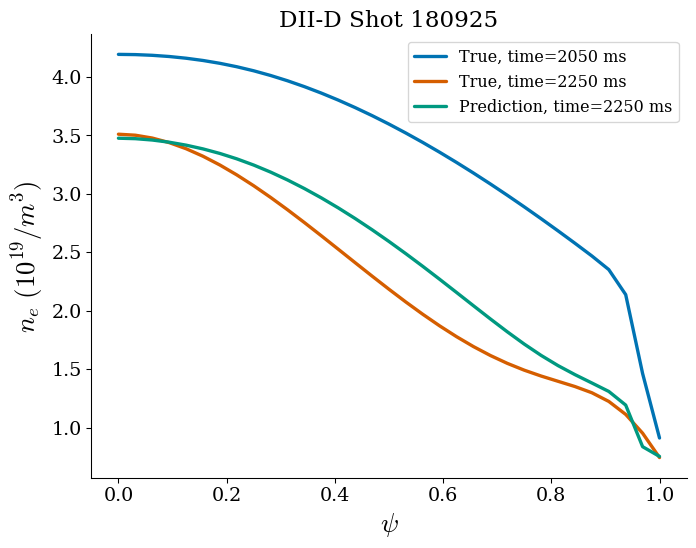

In [90]:
fig, ax = plt.subplots(figsize=(8,6))
psi = np.linspace(0,1,33)

dens = helpers.normalization.denormalize_arr(inputs['input_dens'].squeeze(),scenario['normalization_dict']['dens'])
true = helpers.normalization.denormalize_arr(targets['target_dens'].squeeze()+inputs['input_dens'].squeeze(),scenario['normalization_dict']['dens'])
pred = helpers.normalization.denormalize_arr(predictions[1].squeeze()+inputs['input_dens'].squeeze(),scenario['normalization_dict']['dens'])
ax.set_title('DII-D Shot {:.0f}'.format(times['shots'][0]))
ax.plot(psi,dens,label='True, time={:.0f} ms'.format(times['times'][0]))
ax.plot(psi,true,label='True, time={:.0f} ms'.format(times['times'][0]+200))
ax.plot(psi,pred,label='Prediction, time={:.0f} ms'.format(times['times'][0]+200))
ax.legend()
ax.set_xlabel('$\psi$', size=20)
ax.set_ylabel('$n_e$ $(10^{19}/m^3)$', size=20)

# fig.savefig('dens_plot_for_highlight.pdf')
# fig.savefig('dens_plot_for_highlight.png')